# Домашнее задание 3
## Сравнение интересов аудитории телеканалов НТВ и Дождь с помощью тематического моделирования LDA

Задача:
Сравнить интересы аудитории телеканолов НТВ и Дождь с помощью методов тематического моделирования
1. Получить данные по аудитории из социальной сети ВК
2. Зарегистрировать приложение, получить app_id, access_token
3. Скачать данные по пользователям в каждой из групп (id групп ВК даны ниже, tvrain_id, ntv_id)
4. Взять небольшую выборку из каждой совокупности телезрителей(около 1000-2000 человек, т.к. 300k-400k слишком много), с которыми работать дальше
5. Обучить LDA модель на их подписках
6. По группам, на которые подписаны эти люди, полуичть ключевые слова групп, на которые они подписаны
7. Получить распределение интересов людей для каждой совокупности, сравнить на графике

In [309]:
import seaborn as sns
import sys  
import pandas as pd
import requests
import numpy as np
import datetime
import time
import pickle
import matplotlib.pyplot as plt
import time
%matplotlib inline

from bs4 import BeautifulSoup as bs
import urllib

In [2]:
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

#### Для использования VK API необходимо создать приложение в VK

1. Создать приложение по адресу https://vk.com/apps?act=manage (кнопка "создать приложение")
2. При создании указать название, описание (можно любые), категория  - прочее. Тип - standalone приложение
3. В настройках получить **app_id**. App_id потребуется для получения access token
4. Авторизовать пользователя (получить access token) можно по адресу: https://vk.com/dev/first_guide, в правилах нас интересует пункт 3 **Авторизация пользователя**
5. После того, как ознакомитесь с авторизацией пользователя, скопируйте в адресную строку такой запрос https://oauth.vk.com/authorize?client_id=5490057&display=page&redirect_uri=https://oauth.vk.com/blank.html&scope=friends&response_type=token&v=5.52, где число **5490057** замените на число, которое получите для вашего **app_id**
6. Нажмите Enter. Откроется окно с запросом прав. В нем отображаются название приложения, иконки прав доступа, и Ваши имя с фамилией. Нажмите «Разрешить». Вы попадете на новую страницу с предупреждением о том, что токен нельзя копировать и передавать третьим лицам. В адресной строке будет URL https://oauth.vk.com/blank.html, а после # Вы увидите дополнительные параметры — access_token, expires_in и user_id. Токен может выглядеть, например, так: 51eff86578a3bbbcb5c7043a122a69fd04dca057ac821dd7afd7c2d8e35b60172d45a26599c08034cc40a
7. Токен — это Ваш ключ доступа. При выполнении определенных условий человек, получивший Ваш токен, может нанести существенный ущерб Вашим данным и данным других людей. Поэтому очень важно не передавать свой токен третьим лицам
8. Поле expires_in содержит время жизни токена в секундах. 86400 секунд — это ровно сутки. Через сутки полученный токен перестанет действовать, для продолжения работы нужно будет получить новый по такому же алгоритму

In [73]:
# use your own app id and respective tokens

# скопируйте сюда ваши app_id и access_token, полученные по методу, описанному выше
app_id = 6913823
access_token = '66c612e24a65be6c2d6eefc12b9ca7d26a30a19213dc47a4332136d0030e1a53be84f146582c6c7eb051d'

# id групп ВК Дождя и НТВ
tvrain_id = 17568841
ntv_id = 28658784

In [74]:
# проверка работы API и авторизации пользователя. Если возникает ошибка, то, возможно, access token необходимо обновить
check_id = 5

# api call and test
def vk_get_response(method, parameters, token):
    url = 'https://api.vk.com/method/' + method + '?' + parameters + '&access_token=' + token
#     print url
    return(requests.get(url).json())

answer = vk_get_response(
    'users.get', 'user_ids={0}&v=4.9&lang=ru'.format(check_id), access_token
)['response']
print(answer[0]['first_name'], answer[0]['last_name'])

Илья Перекопский


### Получение подписчиков телеканалов НТВ и Дождь в VK

Получим объекты, которые содержат всю информацию о подписчиках соответствующих групп (указанных в domains) и сохраним их на диск. Получим в итоге два файла - **ntv_subs** и **tvrain_subs** в формате **.pkl** - питоновский формат хранения данных

In [8]:
domains = ['ntv', 'tvrain']


for group_domain in domains:
    offset = 0
    group_id = group_domain
    fields = """sex,bdate,city,country,home_town,lists,domain,has_mobile,
    contacts,connections,education,universities,followers_count,occupation,last_seen,relation"""
    first_sample = vk_get_response(
        'groups.getMembers', 'group_id={0}&offset={1}&fields={2}&v=4.9&lang=ru'.format(
            group_id, offset, fields
        ), token=access_token
    )
    community_count = first_sample['response']['count']
    community_members = []
    for i in range(community_count // 1000 + 1):
        offset = i * 1000
        try:
            answer = vk_get_response(
                'groups.getMembers', 'group_id={0}&offset={1}&fields={2}&v=4.9&lang=ru'.format(
                    group_id, offset, fields), token=access_token
            )
            print("Offset: ", offset)
        except:
            print("Offset: ", offset, " Error")
        community_members += answer['response']['users']
    save_obj(community_members, '{}_subs'.format(group_domain))

Offset:  0
Offset:  1000
Offset:  2000
Offset:  3000
Offset:  4000
Offset:  5000
Offset:  6000
Offset:  7000
Offset:  8000
Offset:  9000
Offset:  10000
Offset:  11000
Offset:  12000
Offset:  13000
Offset:  14000
Offset:  15000
Offset:  16000
Offset:  17000
Offset:  18000
Offset:  19000
Offset:  20000
Offset:  21000
Offset:  22000
Offset:  23000
Offset:  24000
Offset:  25000
Offset:  26000
Offset:  27000
Offset:  28000
Offset:  29000
Offset:  30000
Offset:  31000
Offset:  32000
Offset:  33000
Offset:  34000
Offset:  35000
Offset:  36000
Offset:  37000
Offset:  38000
Offset:  39000
Offset:  40000
Offset:  41000
Offset:  42000
Offset:  43000
Offset:  44000
Offset:  45000
Offset:  46000
Offset:  47000
Offset:  48000
Offset:  49000
Offset:  50000
Offset:  51000
Offset:  52000
Offset:  53000
Offset:  54000
Offset:  55000
Offset:  56000
Offset:  57000
Offset:  58000
Offset:  59000
Offset:  60000
Offset:  61000
Offset:  62000
Offset:  63000
Offset:  64000
Offset:  65000
Offset:  66000
Offset: 

Offset:  155000
Offset:  156000
Offset:  157000
Offset:  158000
Offset:  159000
Offset:  160000
Offset:  161000
Offset:  162000
Offset:  163000
Offset:  164000
Offset:  165000
Offset:  166000
Offset:  167000
Offset:  168000
Offset:  169000
Offset:  170000
Offset:  171000
Offset:  172000
Offset:  173000
Offset:  174000
Offset:  175000
Offset:  176000
Offset:  177000
Offset:  178000
Offset:  179000
Offset:  180000
Offset:  181000
Offset:  182000
Offset:  183000
Offset:  184000
Offset:  185000
Offset:  186000
Offset:  187000
Offset:  188000
Offset:  189000
Offset:  190000
Offset:  191000
Offset:  192000
Offset:  193000
Offset:  194000
Offset:  195000
Offset:  196000
Offset:  197000
Offset:  198000
Offset:  199000
Offset:  200000
Offset:  201000
Offset:  202000
Offset:  203000
Offset:  204000
Offset:  205000
Offset:  206000
Offset:  207000
Offset:  208000
Offset:  209000
Offset:  210000
Offset:  211000
Offset:  212000
Offset:  213000
Offset:  214000
Offset:  215000
Offset:  216000
Offset: 

In [9]:
community_ntv = load_obj('ntv_subs')
community_tvrain = load_obj('tvrain_subs')

In [10]:
community_ntv_df = pd.DataFrame(community_ntv)
community_tvrain_df = pd.DataFrame(community_tvrain)

In [11]:
community_ntv_df.shape,community_tvrain_df.shape

((371983, 30), (444459, 30))

In [12]:
community_ntv_df.head(1)

,bdate,city,country,deactivated,domain,education_form,education_status,facebook,facebook_name,faculty,...,occupation,relation,relation_partner,sex,skype,twitter,uid,universities,university,university_name
0,10.2,2.0,1.0,NaN,rozenkat,NaN,NaN,NaN,NaN,NaN,...,"{'type': 'university', 'id': 1, 'name': 'СПбГУ'}",NaN,NaN,1,NaN,NaN,279,NaN,NaN,NaN


In [13]:
community_tvrain_df.head(1)

,bdate,city,country,deactivated,domain,education_form,education_status,facebook,facebook_name,faculty,...,occupation,relation,relation_partner,sex,skype,twitter,uid,universities,university,university_name
0,NaN,2.0,1.0,NaN,abacabadabacabaeabacabadabacaba,NaN,NaN,NaN,NaN,NaN,...,"{'type': 'university', 'id': 1, 'name': 'СПбГУ'}",NaN,NaN,2,NaN,NaN,6,NaN,NaN,NaN


Сначала получим всех уникальных подписчиков НТВ и Дождя с помощью unique. Далее с помощью numpy.random необходимо выбрать небольшой sample (например, по 1000 из каждой группы) таких людей и объединить их вместе

In [14]:
ntv_uids = community_ntv_df['uid'].unique().tolist()
tvrain_uids = community_tvrain_df['uid'].unique().tolist()

In [15]:
# Мы видим, что в первоначальной выборке uid уже был уникальным
pd.Series(ntv_uids).shape, pd.Series(tvrain_uids).shape

((371983,), (444459,))

In [ ]:
# Может быть такая ситуация , что один и тот же uid подписан и на дождь, и на нтв
# проверим

In [16]:
len(set(ntv_uids) & set(tvrain_uids))

17946

In [17]:
# избавимся от этих uid
common_uid = list(set(ntv_uids) & set(tvrain_uids))
# новые uid
ntv_uids_new = np.setdiff1d(ntv_uids,common_uid)
tvrain_uids_new = np.setdiff1d(tvrain_uids,common_uid)
len(ntv_uids_new), len(tvrain_uids_new)

(354037, 426513)

In [18]:
# получить общий список людей из двух выборок НТВ и Дождя, всего должно быть в итоге около 2000 человек
uids_ntv = np.random.choice(ntv_uids_new, 1000)
uids_tvrain = np.random.choice(tvrain_uids_new, 1000)
#len(uids_ntv), len(uids_tvrain)
uids = np.concatenate((uids_ntv,uids_tvrain))
len(uids)

2000

In [98]:
# получить подписки этих пользователей
%time
print_counter = 0
final_data = []

for uid in uids:
    try:
        user_subs = vk_get_response(
            'users.getSubscriptions', 'user_id={0}&v=4.9&lang=ru'.format(int(uid)), access_token
        )
        time.sleep(0.3)
        user_subs['userid'] = uid
        final_data.append(user_subs)
    except:
        print("Error")
    if print_counter % 100 == 0:
        print("{0} profiles done".format(print_counter))
    print_counter += 1

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.91 µs
0 profiles done
100 profiles done
200 profiles done
Error
300 profiles done
400 profiles done
500 profiles done
600 profiles done
700 profiles done
800 profiles done
900 profiles done
1000 profiles done
1100 profiles done
1200 profiles done
1300 profiles done
1400 profiles done
1500 profiles done
1600 profiles done
1700 profiles done
1800 profiles done
1900 profiles done


In [102]:
# save the data
save_obj(final_data, 'final_data')


In [103]:
# load the data
final_data = load_obj('final_data')

In [105]:
len(final_data)

1999

In [107]:
#final_data[0]

In [23]:
subs_list = []
groups_freq_dict = {}
top_n = 5

for record, uid in zip(final_data, uids):
    try:
        user_subs = record
        if not user_subs.get('response'):
            user_subs = vk_get_response(
                'users.getSubscriptions', 'user_id={0}&v=4.9&lang=ru'.format(int(uid)), access_token
            )
        subs_pd = pd.DataFrame(
            [
                {
                    'groups_count': user_subs['response']['groups'].get('count'),
                    'groups_list': user_subs['response']['groups'].get('items'),
                    'follows_count':user_subs['response']['users'].get('count'),
                    'follows_list': user_subs['response']['users'].get('items'),
                }
            ]
        )

        for group_id in user_subs['response']['groups'].get('items')[:top_n]:
            if groups_freq_dict.get(group_id):
                groups_freq_dict[group_id] += 1
            else:
                groups_freq_dict[group_id] = 1

        subs_pd['subs_count'] = subs_pd['groups_count'] + subs_pd['follows_count']
        subs_list.append(subs_pd)
    except:
#         print(user_subs)
        pass
    if len(subs_list) % 100 == 0:
        print("Processed {0} users".format(len(subs_list)))

Processed 100 users
Processed 200 users
Processed 300 users
Processed 400 users
Processed 500 users
Processed 500 users
Processed 600 users
Processed 700 users
Processed 800 users
Processed 900 users
Processed 1000 users
Processed 1000 users
Processed 1100 users
Processed 1200 users
Processed 1200 users
Processed 1300 users
Processed 1400 users
Processed 1400 users


Самые популярные группы

In [24]:
sorted([(key, val) for key, val in groups_freq_dict.items()], key=lambda x: x[1], reverse=True)[:5]

[(17568841, 226),
 (28658784, 145),
 (15755094, 44),
 (22822305, 38),
 (29534144, 36)]

In [25]:
# посмотрим общее количество групп для наших пользователей
len(groups_freq_dict)

4509

Загрузка постов со стен групп

In [26]:
group_doc_dict = {}
counter = 0
groups_freq_dict_top5 = groups_freq_dict

for group_id, freq in groups_freq_dict_top5.items():
    counter += 1
    try:
        check = vk_get_response(
            'wall.get',
            'owner_id={0}&count=100&fields=post_type,marked_as_ads&&v=4.9&lang=ru'.format(int(group_id) * -1),
            access_token
        )
        check = check['response']
        group_doc = ''
        if check[0] != 0:
            for post in check[1:]:
                if post.get('marked_as_ads') != 1:
                    group_doc += post['text']
        group_doc_dict[group_id] = group_doc
    except:
        print("Response error. Group id {0}".format(group_id))
        #print(check)
    if counter % 100 == 0:
        print("{0} groups extracted".format(counter))
    time.sleep(0.3)

100 groups extracted
200 groups extracted
300 groups extracted
400 groups extracted
500 groups extracted
600 groups extracted
700 groups extracted
Response error. Group id 25705735
Response error. Group id 3491892
800 groups extracted
900 groups extracted
Response error. Group id 23054528
1000 groups extracted
1100 groups extracted
1200 groups extracted
1300 groups extracted
1400 groups extracted
1500 groups extracted
1600 groups extracted
1700 groups extracted
1800 groups extracted
1900 groups extracted
2000 groups extracted
Response error. Group id 85877040
2100 groups extracted
2200 groups extracted
2300 groups extracted
2400 groups extracted
2500 groups extracted
2600 groups extracted
2700 groups extracted
2800 groups extracted
2900 groups extracted
3000 groups extracted
3100 groups extracted
3200 groups extracted
3300 groups extracted
3400 groups extracted
3500 groups extracted
3600 groups extracted
3700 groups extracted
3800 groups extracted
3900 groups extracted
4000 groups extr

In [27]:
# сохранить сырые данные по постам групп на диск
save_obj(group_doc_dict, 'group_doc_dict')

In [28]:
# load the data
group_doc_dict = load_obj('group_doc_dict')

In [29]:
# кол-во постов , которые были успешно добыты
len(group_doc_dict)

4503

In [39]:
from bs4 import BeautifulSoup
import re
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import nltk
from pymorphy2 import MorphAnalyzer

In [44]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/maxim/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [45]:
chrs_to_delete = string.punctuation + u'»' + u'«' + u'—' + u'“' + u'„' + u'•' + u'#'
translation_table = {ord(c): None for c in chrs_to_delete if c != u'-'}
units = MorphAnalyzer.DEFAULT_UNITS
morph = MorphAnalyzer(result_type=None, units=units)
PortSt = PorterStemmer()
stopw = set(
    [w for w in stopwords.words(['russian', 'english'])]
    + [u'это', u'году', u'года', u'также', u'етот',
       u'которые', u'который', u'которая', u'поэтому',
       u'весь', u'свой', u'мочь', u'eтот', u'например',
       u'какой-то', u'кто-то', u'самый', u'очень', u'несколько',
       u'источник', u'стать', u'время', u'пока', u'однако',
       u'около', u'немного', u'кроме', u'гораздо', u'каждый',
       u'первый', u'вполне', u'из-за', u'из-под',
       u'второй', u'нужно', u'нужный', u'просто', u'большой',
       u'хороший', u'хотеть', u'начать', u'должный', u'новый', u'день',
       u'метр', u'получить', u'далее', u'именно', u'апрель',
       u'сообщать', u'разный', u'говорить', u'делать',
       u'появиться', u'2016', u'март', u'2019', u'человек',
       u'2015', u'получить', u'иметь', u'составить', u'дать', u'читать',
       u'ничто', u'достаточно', u'использовать',
       u'принять', u'практически', u'жизнь',
       u'находиться', u'месяц', u'достаточно', u'что-то', u'часто',
       u'хотеть', u'начаться', u'делать', u'событие', u'составлять',
       u'остаться', u'заявить', u'сделать', u'дело',
       u'примерно', u'попасть', u'хотя', u'лишь', u'первое',
       u'больший', u'решить', u'число', u'идти', u'давать', u'вопрос',
       u'сегодня', u'часть', u'высокий', u'главный', u'случай', u'место',
       u'конец', u'работать', u'работа', u'слово', u'важный', u'сказать']
)

In [46]:
url_start = 'http[s]?://'
url_end = (
    '(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
)
pattern = url_start + url_end

Обработка слов постов групп - трансформация в "хороший" вид. Нормализация и стэмминг, удаление стоп-слов

In [48]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/maxim/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [49]:
group_clean_doc_dict = {}
counter = 0

for group_id, doc in group_doc_dict.items():
    soup = BeautifulSoup(doc, 'html.parser')
    body = ' '.join(
        [tag.string.replace('\\n', ' ').replace('\\r', ' ')
         for tag in soup.descendants if tag.string]
    )
    body = re.sub('\[.*?\]','', body)
    body = re.sub(pattern,'', body)
    if body != '':
        body_clean = body.translate(translation_table).lower().strip()
        words = word_tokenize(body_clean)
        tokens = []
        # stemming and text normalization
        for word in words:
            if re.match('^[a-z0-9-]+$', word) is not None:
                tokens.append(PortSt.stem(word))
            elif word.count('-') > 1:
                tokens.append(word)
            else:
                normal_forms = morph.normal_forms(word)
                tokens.append(normal_forms[0] if normal_forms else word)
        # remove stopwords and leave unique words only
        tokens = filter(
            lambda token: token not in stopw, sorted(set(tokens))
        )

        # remove all words with more than 3 chars
        tokens = filter(lambda token: len(token) > 3, tokens)
    else:
        tokens = []
    counter += 1
    if counter % 100 == 0:
        print("{0} docs processed".format(counter))
    group_clean_doc_dict[group_id] = tokens

group_clean_doc_dict = {key: list(val) for key, val in group_clean_doc_dict.items()}

100 docs processed
200 docs processed
300 docs processed
400 docs processed
500 docs processed
600 docs processed
700 docs processed
800 docs processed
900 docs processed
1000 docs processed
1100 docs processed
1200 docs processed
1300 docs processed
1400 docs processed
1500 docs processed
1600 docs processed
1700 docs processed
1800 docs processed
1900 docs processed
2000 docs processed
2100 docs processed
2200 docs processed
2300 docs processed
2400 docs processed
2500 docs processed
2600 docs processed
2700 docs processed
2800 docs processed
2900 docs processed
3000 docs processed
3100 docs processed
3200 docs processed
3300 docs processed
3400 docs processed
3500 docs processed
3600 docs processed
3700 docs processed
3800 docs processed
3900 docs processed
4000 docs processed
4100 docs processed
4200 docs processed
4300 docs processed
4400 docs processed
4500 docs processed


In [50]:
# сохранить обработанные данные на диск
save_obj(group_clean_doc_dict, 'group_doc_dict_clean')

In [51]:
group_clean_doc_dict = load_obj('group_doc_dict_clean')
len(group_clean_doc_dict)

4503

### Обучение LDA модели

In [54]:
from gensim.corpora import TextCorpus
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.ldamodel import LdaModel

class ListTextCorpus(TextCorpus):

    def get_texts(self):
        for doc in self.input:
            yield doc
                


In [55]:
mycorp = ListTextCorpus(input=group_clean_doc_dict.values())

In [57]:
justlda = LdaModel(
    corpus=mycorp, num_topics=20, passes=12
)

In [66]:
# LdaModel performance
print('LdaModel performance')
for i in range(20):
    terms = justlda.get_topic_terms(i)
    print(i, ' '.join(map(lambda x: mycorp.dictionary.get(x[0]), terms)))

LdaModel performance
0 надуться күңелла белән гузель күрепа насыйп матур шулай булсын китта
1 американский джон национальный франция 1999 эпоха основать король британский боевик
2 резчик 1226 1557 четырехглавый 1222 мена промплощадка косынка хадис стянуться
3 засомневаться finland topshop бета-тест предзаказать мультиплеерный кроп batman playstat store
4 звонить телефон магазин адрес номер писать рубль ждать пожалуйста группа
5 котёнок щенок собака малыш нибыть кушать выкинуть собачка животик потеряшка
6 українить який середа буде український коли міст якщый рокіть такожа
7 music трек love time live hous like black world альбом
8 cтaть мoжнo бoльшe cдeлaть пocлe тoлькo вpeмить cвoть кoтopыe ecть
9 авто задний цена машина фото двигатель телефон диск писать комплект
10 матч команда сезон игрок сборный клуб чемпион чемпионат турнир игра
11 этoгo тoлькo тoгo дeнь дeлaть тaкий чepeз пoмoщь этoт чтoб
12 масло приготовление рецепт ингредиент соль литр ложка яйцо молоко сухой
13 foto знать под

In [186]:
# Group distribution by the most relevant topic
dummy_dict = {key: 0 for key in range(20)}

group_topics_dict_20 = {
    group_id: dict(list(dummy_dict.items()) + justlda.get_document_topics(mycorp.dictionary.doc2bow(text)))
    for group_id, text in group_clean_doc_dict.items()
}
check_pd_20 = pd.DataFrame.from_dict(group_topics_dict_20, orient='index')
check_pd_20.head(10)
print("Group distribution by the most relevant topic")
pd.Series.round(check_pd_20.idxmax(axis=1).value_counts() * 1. / len(check_pd_20), 4)

Group distribution by the most relevant topic


14    0.5667
18    0.1295
12    0.0402
10    0.0318
16    0.0295
19    0.0255
9     0.0251
4     0.0242
8     0.0222
0     0.0204
6     0.0140
7     0.0124
15    0.0109
13    0.0100
11    0.0100
1     0.0082
5     0.0062
17    0.0062
3     0.0042
2     0.0027
dtype: float64

In [ ]:
# top 5 topics - 14, 18, 12, 10, 16

In [68]:
# dump lda model to disk
justlda.save('ldamodel_20_topics')

In [75]:
# The most typical groups for every topic
print("The most typical groups for every topic")
for i in range(20):
    terms = justlda.get_topic_terms(i)
    print(i, ' '.join(map(lambda x: mycorp.dictionary.get(x[0]), terms)))
    typical_groups = check_pd_20[i].sort_values(ascending=False).index[:10]
    for g in typical_groups:
        group_info = vk_get_response(
            'groups.getById', 'group_ids={0}&v=4.9&lang=ru'.format(g), access_token
        )
        print(group_info['response'][0]['name'] + ' ' + 'http://vk.com/club' + str(g))
        time.sleep(0.3)
    print()
# top 5 topics - 14, 18, 12, 10, 16    

The most typical groups for every topic
0 надуться күңелла белән гузель күрепа насыйп матур шулай булсын китта
Гузель Уразова | OFFICIAL GROUP http://vk.com/club151516202
✿Яңа җырлар һәм котлаулар✿ ТАТАРСТАН| КАЗАНЬ-УФА http://vk.com/club70660094
SFAP  |  Спортивные девушки http://vk.com/club33390409
Иң шәп татарча җырлар | Татарстан| Казань| Челны http://vk.com/club29532414
Sex Room | Секс Комната http://vk.com/club31904789
Спам казакша 👌👌👌👍 http://vk.com/club96720197
Путешествия http://vk.com/club38363244
Afro-American Side Of The Moon http://vk.com/club154906069
Мужские мысли http://vk.com/club25397178
KLUKVA TUNE http://vk.com/club61007420

1 американский джон национальный франция 1999 эпоха основать король британский боевик
кусочек фильма http://vk.com/club70493648
Men's Atmosphere http://vk.com/club84838988
Vexillum http://vk.com/club63281087
Привет с колес (Горно-алтайск) http://vk.com/club108348308
(੭ˊ꒳​ˋ)੭ рр-р-рай мастера http://vk.com/club137194173
EPSCAPE | Кино и сериалы h

BV GYM | Калуга http://vk.com/club150834123
Начни с себя! http://vk.com/club50636235
L'ONE http://vk.com/club38213334
Змееносец http://vk.com/club33755740
Korosnetick Blondin http://vk.com/club171815870
ПСИХОЛОГИЯ http://vk.com/club31862851
Zoobe Зайка. Официальная группа ВК! http://vk.com/club134630563
Блог Макса Мироненко http://vk.com/club177064930

15 pull вопросительный parent pari haunt form empti wright 1964 spencer
Тото Кутуньо | Toto Cutugno http://vk.com/club144259022
MEN'S TOYS | Мужской журнал http://vk.com/club8152581
АРТ искусство http://vk.com/club25813425
COCO - Преподаватель итальянского - Носитель http://vk.com/club110715289
Tigrr http://vk.com/club123124404
P L E Λ S U R E http://vk.com/club98885822
AWESOME STORE http://vk.com/club41711991
Параллельная Вселенная http://vk.com/club64861119
FRISKY Radio http://vk.com/club42311167
Убойный юмор http://vk.com/club30179569

16 любить жить твой любовь друг мeнить знать любимый женщина думать
МОЛОДЫЕ http://vk.com/club163840

In [ ]:
# Воспользуемся функцией из лекции для подсчета "велечины интереса паблика у пользователей"

In [221]:
from operator import add

def groups_to_topics_v1(groups_list, n=5):
    counter = 1
    probs_sum = dummy_dict.values()
    for group_id in groups_list:
        topics_dict = group_topics_dict_20.get(group_id)
        rel_topic_probs = map(
            lambda x: x * (min(5, n) - counter + 1),
            dummy_dict.values() if not topics_dict else topics_dict.values()
        )
        probs_sum = map(add, probs_sum, rel_topic_probs)
        if counter == 5:
            break
        counter += 1
    return map(lambda x: x / sum([x + 1 for x in range(counter)]), probs_sum)

In [ ]:
# Чтобы воспользоваться функцией groups_to_topics_v1 нам потребуются списки для нтв и доджя

In [219]:
def groups_separate(uids, final_data):
    groups_list = []
    for j in uids:
        for i in range(0, len(final_data)):
            if j == final_data[i]['userid']:
                try:
                    groups_list.append(final_data[i]['response']['groups']['items'])
                except KeyError:
                    continue

In [165]:
groups_list_ntv = groups_separate(uids_ntv, final_data)
len(groups_list_ntv)

729

In [167]:
groups_list_tvrain = groups_separate(uids_tvrain, final_data)
len(groups_list_tvrain)

774

In [182]:
# Получился список со вложенными списками. Избавимся от него и оставим только уникальные группы
#import itertools
#merged_list_ntv = set(list(itertools.chain(*groups_list_ntv)))
#merged_list_tvrain = set(list(itertools.chain(*groups_list_tvrain)))

In [223]:
# создадим матрицу zeros и заполним ее значениями из фу-ии groups_to_topics_v1 для нтв
ntv_rate_topics = np.zeros(20)
for i in range(0, len(groups_list_ntv)):
    ntv_rate_topics += np.array(list(groups_to_topics_v1(groups_list_ntv[i])))

In [287]:
ntv_rate_topics

array([  2.44838316,   5.40029681,   2.65594915,   3.43374286,
         6.31169162,   3.39905675,   2.70099833,   8.12387093,
         4.15168325,   6.28815068,   9.88371433,   2.85758423,
        10.85494859,   2.39586218, 104.7965587 ,   2.65871531,
        10.54777251,   3.62697408,  58.42201234,   4.87001737])

In [243]:
# создадим матрицу zeros и заполним ее значениями из фу-ии groups_to_topics_v1 для дождя
tvrain_rate_topics = np.zeros(20)
for i in range(0, len(groups_list_tvrain)):
    tvrain_rate_topics += np.array(list(groups_to_topics_v1(groups_list_tvrain[i])))

In [244]:
tvrain_rate_topics

array([  0.97710336,   5.70063205,   0.96145196,   1.77471303,
         4.25552705,   1.72909961,   7.03290413,   6.61311407,
         4.9550208 ,   3.63752545,   6.58956351,   3.07786933,
         9.66279673,   2.6910806 , 141.2549939 ,   4.89189828,
         8.46262498,   2.50218359,  52.56183885,   4.80025073])

In [ ]:
# convert ntv_rate_topics to dict (for data frame)

In [288]:
a = list(dummy_dict)
b = [ntv_rate_topics[i] for i in range(0, 20)]

ntv_rate_topics_dict = dict(zip(a,b))

In [289]:
# convert tvrain_rate_topics to dict (for data frame)

In [291]:
a = list(dummy_dict)
c = [tvrain_rate_topics[i] for i in range(0, 20)]

tvrain_rate_topics_dict = dict(zip(a,c))

In [293]:
#Составим словарь: это номер топика - ключевые слова топика (for data frame)
topics_names_dict = {}
for i in range(20):
    terms = justlda.get_topic_terms(i)
    topics_names_dict[i] = ' '.join(map(lambda x: mycorp.dictionary.get(x[0]), terms))

In [296]:
# create df
df = pd.DataFrame([topics_names_dict, ntv_rate_topics_dict, tvrain_rate_topics_dict]).T
df.columns = ['Топик', 'НТВ', 'Дождь']


In [298]:
df.head(1)

,Топик,НТВ,Дождь
0,надуться күңелла белән гузель күрепа насыйп ма...,2.44838,0.977103


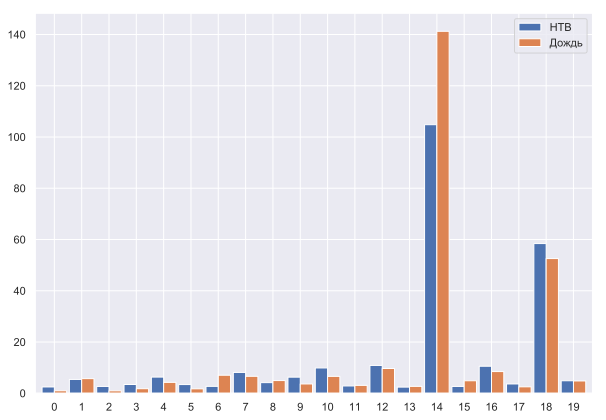

In [330]:
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg'
df[['НТВ', 'Дождь']].plot(kind='bar', figsize=(10, 7), rot=0, width = .9);

In [332]:
# выделяются два топика - 14 (интересный топик :) ), 18. Если ими пренебречь , то распределение можно счтиать нормальным, т,е, различий
# существенных между подписчиками нет
# на 6 топик, связанный с Украиной , больше на дожде, но это закономерно , как по мне, так украинцы больше 
# доверяют/читают независимое СМИ
topics_names_dict

{0: 'надуться күңелла белән гузель күрепа насыйп матур шулай булсын китта',
 1: 'американский джон национальный франция 1999 эпоха основать король британский боевик',
 2: 'резчик 1226 1557 четырехглавый 1222 мена промплощадка косынка хадис стянуться',
 3: 'засомневаться finland topshop бета-тест предзаказать мультиплеерный кроп batman playstat store',
 4: 'звонить телефон магазин адрес номер писать рубль ждать пожалуйста группа',
 5: 'котёнок щенок собака малыш нибыть кушать выкинуть собачка животик потеряшка',
 6: 'українить який середа буде український коли міст якщый рокіть такожа',
 7: 'music трек love time live hous like black world альбом',
 8: 'cтaть мoжнo бoльшe cдeлaть пocлe тoлькo вpeмить cвoть кoтopыe ecть',
 9: 'авто задний цена машина фото двигатель телефон диск писать комплект',
 10: 'матч команда сезон игрок сборный клуб чемпион чемпионат турнир игра',
 11: 'этoгo тoлькo тoгo дeнь дeлaть тaкий чepeз пoмoщь этoт чтoб',
 12: 'масло приготовление рецепт ингредиент соль литр